# Team 9 | Project - Loan Default Prediction

**This notebook contains the codes and results of other models that we tried initially in order to narrow down to the best classifier. We have not used PCA for this analysis**

## Importing Packages

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, StratifiedKFold, KFold
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,precision_score,recall_score,roc_auc_score,roc_curve
from xgboost import XGBClassifier
# from catboost import CatBoostClassifier, Pool, cv
from lightgbm import LGBMClassifier
from tqdm import tqdm
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading Training and Test Data

In [39]:
fx = pd.read_csv("/content/drive/MyDrive/MyPC/Sem 7/IDA project/train_x.csv").set_index('ID')
fy = pd.read_csv("/content/drive/MyDrive/MyPC/Sem 7/IDA project/train_y.csv").set_index('ID')
test_data = pd.read_csv("/content/drive/MyDrive/MyPC/Sem 7/IDA project/test_x.csv").set_index('ID_Test')

## Imputation of Categorical and Ordinal Features

The Ordinal (Age) and Categorical features (Loan Type, Occupation Type) were imputed with the most frequent value corresponding to the class

In [40]:
from scipy import stats
print('Most Frequent Age for Class 0: ',stats.mode(fx['Age'].loc[(fy==0)['Label']])[0][0])
print('Most Frequent Loan Type for Class 0: ',stats.mode(fx['Loan type'].loc[(fy==0)['Label']])[0][0])
print('Most Frequent Occupation Type for Class 0: ',stats.mode(fx['Occupation type'].loc[(fy==0)['Label']])[0][0])
print()
print('Most Frequent Age for Class 1: ',stats.mode(fx['Age'].loc[(fy==1)['Label']])[0][0])
print('Most Frequent Loan Type for Class 1: ',stats.mode(fx['Loan type'].loc[(fy==1)['Label']])[0][0])
print('Most Frequent Occupation Type for Class 1: ',stats.mode(fx['Occupation type'].loc[(fy==1)['Label']])[0][0])

Most Frequent Age for Class 0:  0.0
Most Frequent Loan Type for Class 0:  A
Most Frequent Occupation Type for Class 0:  Y

Most Frequent Age for Class 1:  1.0
Most Frequent Loan Type for Class 1:  B
Most Frequent Occupation Type for Class 1:  Y


In [41]:
#Age Feature
id = fx['Age'][np.isnan(fx['Age'])].index
id1 = fx['Age'][np.isnan(fx['Age'])][(fy.loc[np.array(id)] == 0)['Label']].index 
fx['Age'].loc[id1] = fx['Age'][np.isnan(fx['Age'])][(fy.loc[np.array(id)] == 0)['Label']].replace(np.nan, 0)

id2 = fx['Age'][np.isnan(fx['Age'])][(fy.loc[np.array(id)] == 1)['Label']].index 
fx['Age'].loc[id2] = fx['Age'][np.isnan(fx['Age'])][(fy.loc[np.array(id)] == 1)['Label']].replace(np.nan, 1)

#Loan Type Feature
id =  fx['Loan type'][pd.isnull(fx['Loan type'])].index

id1 = fx['Loan type'][pd.isnull(fx['Loan type'])][(fy.loc[np.array(id)] == 0)['Label']].index 
fx['Loan type'].loc[id1] = fx['Loan type'][pd.isnull(fx['Loan type'])][(fy.loc[np.array(id)] == 0)['Label']].replace(np.nan, 'A')

id2 = fx['Loan type'][pd.isnull(fx['Loan type'])][(fy.loc[np.array(id)] == 1)['Label']].index 
fx['Loan type'].loc[id2] = fx['Loan type'][pd.isnull(fx['Loan type'])][(fy.loc[np.array(id)] == 1)['Label']].replace(np.nan, 'B')

#Occupation Type Feature
id =  fx['Occupation type'][pd.isnull(fx['Occupation type'])].index
fx['Occupation type'].loc[id] =  fx['Occupation type'].loc[id].replace(np.nan,'Y')

## Iterative Imputation for Numerical Features

In [42]:
# Iterative imputer
imp = IterativeImputer(missing_values = np.nan, max_iter = 10, random_state = 42,verbose=1)

# One Hot Encoding of categorical features Loan Type and Occupation Type
fx_loan_type = pd.get_dummies(fx['Loan type'], prefix = 'Loan type')
fx_occupation = pd.get_dummies(fx['Occupation type'], prefix = 'Occupation type')

cols = list(fx.columns);
cols.remove('Loan type'); cols.remove('Occupation type');

fx = pd.concat([fx[cols], fx_loan_type, fx_occupation],axis = 1)
imp.fit(fx)
p = list(imp.transform(fx))
y = list(fy['Label'])

[IterativeImputer] Completing matrix with shape (80000, 13)
[IterativeImputer] Change: 4072.2446953765193, scaled tolerance: 20.72891533 
[IterativeImputer] Change: 4066.959594631126, scaled tolerance: 20.72891533 
[IterativeImputer] Change: 760.2445291387521, scaled tolerance: 20.72891533 
[IterativeImputer] Change: 548.4206595597784, scaled tolerance: 20.72891533 
[IterativeImputer] Change: 397.30854102846934, scaled tolerance: 20.72891533 
[IterativeImputer] Change: 253.810880458469, scaled tolerance: 20.72891533 
[IterativeImputer] Change: 191.99084863988764, scaled tolerance: 20.72891533 
[IterativeImputer] Change: 254.86686987255734, scaled tolerance: 20.72891533 
[IterativeImputer] Change: 34.70309814903885, scaled tolerance: 20.72891533 
[IterativeImputer] Change: 17.867956365225382, scaled tolerance: 20.72891533 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (80000, 13)


## Preprocessing and Nonlinear Feature Transformation

We have included only those data points that have proper labels, and ignored those that have missing labels.

In [43]:
# Including values that have labels in the final dataset
x_matrix = []
y_matrix = []
for i in range(len(p)):
    if fy['Label'][i+1] in [0,1]:
      x_matrix.append(p[i])
      y_matrix.append(y[i])

df_x = pd.DataFrame(x_matrix, columns = fx.columns)
df_y = y_matrix

## Other Approaches (apart from the best LGBM model)

### Train-Validation Split

In [46]:
X_train, X_val, y_train, y_val = train_test_split(np.array(x_matrix), df_y, test_size = 0.2,random_state = 42)

### Random Forest

In [47]:
RF_classifier = RandomForestClassifier(n_estimators=100)
RF_classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [48]:
y_pred_train = RF_classifier.predict(X_train)
y_pred_val = RF_classifier.predict(X_val)
y_pred_prob = RF_classifier.predict_proba(X_val)
roc_RF = roc_curve(y_val, y_pred_prob[:,1])

In [49]:
print('Validation Accuracy: ',accuracy_score(y_val,y_pred_val))
print('F1 Score Accuracy: ',f1_score(y_val,y_pred_val))
print('ROC AUC: ',roc_auc_score(y_val,y_pred_prob[:,1]))
print('Confusion Matrix:')
pd.DataFrame(confusion_matrix(y_val,y_pred_val))

Validation Accuracy:  0.9837056504599212
F1 Score Accuracy:  0.8603603603603602
ROC AUC:  0.9713606601248368
Confusion Matrix:


,0,1
0,14208,44
1,204,764


### Adaboost with RF as base estimator

In [82]:
clf_RF = RandomForestClassifier(n_estimators=50,max_depth=10,verbose=0,n_jobs=4)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0,base_estimator=clf_RF)
clf_ada.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=RandomForestClassifier(bootstrap=True,
                                                         ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=10,
                                                         max_features='auto',
                                                         max_leaf_nodes=None,
                                                         max_samples=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                         

In [83]:
y_pred_train = clf_ada.predict(X_train)
y_pred_val = clf_ada.predict(X_val)
y_pred_prob = clf_ada.predict_proba(X_val)
roc_ada = roc_curve(y_val, y_pred_prob[:,1])

In [52]:
print('Validation Accuracy: ',accuracy_score(y_val,y_pred_val))
print('F1 Score: ',f1_score(y_val,y_pred_val))
print('ROC AUC: ',roc_auc_score(y_val,y_pred_prob[:,1]))
print('Confusion Matrix:')
pd.DataFrame(confusion_matrix(y_val,y_pred_val))

Validation Accuracy:  0.9847568988173456
F1 Score:  0.8681818181818182
ROC AUC:  0.9747515500216876
Confusion Matrix:


,0,1
0,14224,28
1,204,764


### XGBoost

In [53]:
xgb_clf = XGBClassifier(n_estimators=500,
                      max_depth=15,
                      learning_rate=0.12,
                      objective='binary:logistic',
                      subsample=0.7,
                      colsample_bytree=0.7,
                      scale_pos_weight=2.20,
                      # num_parallel_tree = 10,
                      random_state=123,verbosity=1)
xgb_clf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0,
              learning_rate=0.12, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=123,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2.2, seed=None,
              silent=None, subsample=0.7, verbosity=1)

In [86]:
y_pred_train = xgb_clf.predict(X_train)
y_pred_val = xgb_clf.predict(X_val)
y_pred_prob = xgb_clf.predict_proba(X_val)
roc_XG = roc_curve(y_val, y_pred_prob[:,1])

In [55]:
print('Validation Accuracy: ',accuracy_score(y_val,y_pred_val))
print('F1 Score: ',f1_score(y_val,y_pred_val))
print('ROC AUC: ',roc_auc_score(y_val,y_pred_prob[:,1]))
print('Confusion Matrix:')
pd.DataFrame(confusion_matrix(y_val,y_pred_val))

Validation Accuracy:  0.9854139290407359
F1 Score:  0.8776185226019846
ROC AUC:  0.9727624859958759
Confusion Matrix:


,0,1
0,14202,50
1,172,796


### Light Gradient Boosting Classifier

In [65]:
lgbm_clf = LGBMClassifier(n_estimators=1500,
                       max_depth=14,
                       learning_rate=0.12, 
                       objective='binary',
                       subsample=0.6,
                       colsample_bytree=1.,
                       num_parallel_tree = 10,
                       scale_pos_weight=2.20,
                       random_state=123,
                       reg_alpha = 0
                       )
lgbm_clf.fit(X_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.12, max_depth=14,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=1500, n_jobs=-1, num_leaves=31,
               num_parallel_tree=10, objective='binary', random_state=123,
               reg_alpha=0, reg_lambda=0.0, scale_pos_weight=2.2, silent=True,
               subsample=0.6, subsample_for_bin=200000, subsample_freq=0)

In [67]:
y_pred_train = lgbm_clf.predict(X_train)
y_pred_val = lgbm_clf.predict(X_val)
y_pred_prob = lgbm_clf.predict_proba(X_val)
roc_LGBM = roc_curve(y_val, y_pred_prob[:,1])

In [68]:
print('Validation Accuracy: ',accuracy_score(y_val,y_pred_val))
print('F1 Score: ',f1_score(y_val,y_pred_val))
print('ROC AUC: ',roc_auc_score(y_val,y_pred_prob[:,1]))
print('Confusion Matrix:')
pd.DataFrame(confusion_matrix(y_val,y_pred_val))

Validation Accuracy:  0.9862023653088042
F1 Score:  0.8838495575221239
ROC AUC:  0.9758106300290172
Confusion Matrix:


,0,1
0,14211,41
1,169,799


### Gradient Boosting Classifier

In [69]:
clf_GBC = GradientBoostingClassifier(n_estimators=600, learning_rate=0.5, max_depth=5, random_state=0,verbose=1,min_samples_leaf = 1000).fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           0.3377            3.96m
         2           0.2757            3.89m
         3           0.2398            3.91m
         4           0.2214            3.95m
         5           0.2027            3.89m
         6           0.1827            3.88m
         7           0.1746            3.84m
         8           0.1714            3.84m
         9           0.1684            3.84m
        10           0.1572            3.81m
        20           0.1319            3.71m
        30           0.1153            3.64m
        40           0.1064            3.56m
        50           0.0977            3.49m
        60           0.0921            3.43m
        70           0.0871            3.36m
        80           0.0830            3.30m
        90           0.0788            3.23m
       100           0.0757            3.17m
       200           0.0527            2.53m
       300           0.0384            1.90m
       40

In [70]:
y_pred_train = clf_GBC.predict(X_train)
y_pred_val = clf_GBC.predict(X_val)
y_pred_prob = clf_GBC.predict_proba(X_val)
roc_GBC = roc_curve(y_val, y_pred_prob[:,1])

In [61]:
print('Validation Accuracy: ',accuracy_score(y_val,y_pred_val))
print('F1 Score: ',f1_score(y_val,y_pred_val))
print('ROC AUC: ',roc_auc_score(y_val,y_pred_prob[:,1]))
print('Confusion Matrix:')
pd.DataFrame(confusion_matrix(y_val,y_pred_val))

Validation Accuracy:  0.9835085413929041
F1 Score:  0.8614025400331309
ROC AUC:  0.9700996728311873
Confusion Matrix:


,0,1
0,14189,63
1,188,780


## Plotting ROC Curve

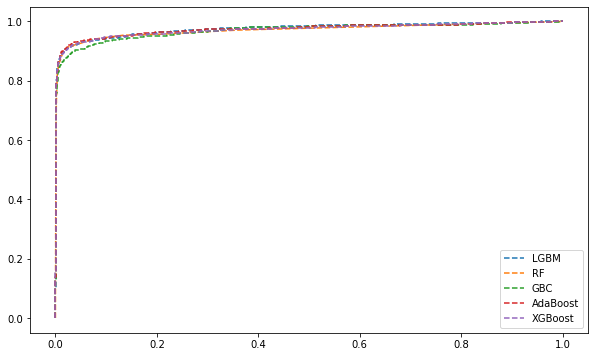

In [89]:
plt.figure(figsize=(10,6))
plt.plot(roc_LGBM[0],roc_LGBM[1],'--')
plt.plot(roc_RF[0],roc_RF[1],'--')
plt.plot(roc_GBC[0],roc_GBC[1],'--')
plt.plot(roc_ada[0],roc_ada[1],'--')
plt.plot(roc_XG[0],roc_XG[1],'--')
plt.legend(['LGBM','RF','GBC','AdaBoost','XGBoost'])